# CW02 - GUI paper exploration 2 - Bump hunt reference

Motivation: Show a classical bump-hunt example + comparison with Dynesty + benefits of a CNN (although those are weak in the current example).

In [8]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [10]:
import dynesty
import swyft

## Workflow: ZoomTask

In [11]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

## Model

In [12]:
COUNTER = 0  # Counter for number of likelihood evaluations (relevant for Dynesty)

In [13]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

In [14]:
# Noise-free model

# Model and reference parameters
def spec(a, b, c, d, LW = 0.3):
    global COUNTER
    COUNTER += 1
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    y = spec(v[0], v[1], v[2], v[3])
    noise = 0*np.random.randn(N)*SIGMA
    return dict(y=y + noise)

# Noise model
def noise(sim, v, sigma = SIGMA):
    #return sim
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

## Dynesty analysis

In [19]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-4., 8.).ppf(u[0])
    b = scipy.stats.uniform(-4., 8.).ppf(u[1])
    c = scipy.stats.uniform(0, 10.).ppf(u[2])
    d = scipy.stats.uniform(0, 10.).ppf(u[3])
    return np.array([a, b, c, d])

In [22]:
v0 = np.array([0.0, 0, 5., 4.])
obs0 = noise(model(v0), v0)

In [23]:
def loglike(v):    
    mu = model(v)['y']
    return -0.5*sum((obs0['y'] - mu)**2)

In [24]:
ns = dynesty.NestedSampler(loglike, transform, 4)
ns.run_nested()
print(COUNTER)

59it [00:00, 289.57it/s, bound: 0 | nc: 2 | ncall: 563 | eff(%): 10.480 | loglstar:   -inf < -14129.947 <    inf | logz: -14136.973 +/-  0.168 | dlogz: 14160.243 >  0.509]

2 0.002


1771it [00:51,  6.46it/s, bound: 1 | nc: 1 | ncall: 17758 | eff(%):  9.973 | loglstar:   -inf < -204.141 <    inf | logz: -212.600 +/-  0.170 | dlogz: 172.816 >  0.509]    

3 5.811592623566925e-05


1942it [00:54, 63.84it/s, bound: 2 | nc: 6 | ncall: 18515 | eff(%): 10.489 | loglstar:   -inf < -177.769 <    inf | logz: -186.008 +/-  0.170 | dlogz: 145.799 >  0.509] 

3 4.129664610800827e-05


2089it [00:56, 73.63it/s, bound: 3 | nc: 5 | ncall: 19292 | eff(%): 10.828 | loglstar:   -inf < -162.490 <    inf | logz: -170.328 +/-  0.167 | dlogz: 129.738 >  0.509] 

3 3.185011340101897e-05


2350it [00:59, 83.22it/s, bound: 4 | nc: 4 | ncall: 20048 | eff(%): 11.722 | loglstar:   -inf < -137.867 <    inf | logz: -145.715 +/-  0.168 | dlogz: 116.430 >  0.509] 

3 1.8869828009839833e-05


2613it [01:02, 74.13it/s, bound: 5 | nc: 2 | ncall: 20799 | eff(%): 12.563 | loglstar:   -inf < -120.049 <    inf | logz: -128.615 +/-  0.175 | dlogz: 98.815 >  0.509]  

3 1.0936540454415813e-05


2883it [01:05, 94.33it/s, bound: 6 | nc: 3 | ncall: 21555 | eff(%): 13.375 | loglstar:   -inf < -106.508 <    inf | logz: -115.509 +/-  0.178 | dlogz: 85.162 >  0.509]  

3 6.4923906570976716e-06


3185it [01:07, 134.90it/s, bound: 7 | nc: 2 | ncall: 22305 | eff(%): 14.279 | loglstar:   -inf < -94.006 <    inf | logz: -103.586 +/-  0.184 | dlogz: 72.635 >  0.509] 

3 3.6010304388064097e-06


3461it [01:10, 102.38it/s, bound: 8 | nc: 8 | ncall: 23061 | eff(%): 15.008 | loglstar:   -inf < -77.509 <    inf | logz: -87.875 +/-  0.191 | dlogz: 59.498 >  0.509] 

3 2.037633893642945e-06


3713it [01:12, 130.06it/s, bound: 9 | nc: 4 | ncall: 23829 | eff(%): 15.582 | loglstar:   -inf < -64.954 <    inf | logz: -75.587 +/-  0.193 | dlogz: 46.690 >  0.509] 

3 1.2766719534247404e-06


4005it [01:14, 117.47it/s, bound: 10 | nc: 1 | ncall: 24563 | eff(%): 16.305 | loglstar:   -inf < -53.824 <    inf | logz: -64.600 +/-  0.197 | dlogz: 35.105 >  0.509]

3 6.913354190889784e-07


4244it [01:17, 95.35it/s, bound: 11 | nc: 2 | ncall: 25331 | eff(%): 16.754 | loglstar:   -inf < -47.292 <    inf | logz: -58.283 +/-  0.199 | dlogz: 28.302 >  0.509] 

3 4.279919889841049e-07


4497it [01:19, 122.81it/s, bound: 12 | nc: 2 | ncall: 26068 | eff(%): 17.251 | loglstar:   -inf < -41.203 <    inf | logz: -52.377 +/-  0.202 | dlogz: 21.884 >  0.509]

3 2.612813563543953e-07


4832it [01:21, 127.08it/s, bound: 13 | nc: 3 | ncall: 26821 | eff(%): 18.016 | loglstar:   -inf < -35.843 <    inf | logz: -47.402 +/-  0.205 | dlogz: 16.236 >  0.509]

3 1.3352235616655025e-07


5169it [01:24, 144.02it/s, bound: 14 | nc: 3 | ncall: 27583 | eff(%): 18.740 | loglstar:   -inf < -31.690 <    inf | logz: -43.640 +/-  0.208 | dlogz: 11.797 >  0.509]

3 6.864402131615718e-08


5505it [01:26, 135.36it/s, bound: 15 | nc: 3 | ncall: 28320 | eff(%): 19.439 | loglstar:   -inf < -28.841 <    inf | logz: -41.012 +/-  0.210 | dlogz:  8.494 >  0.509]

3 3.479985199532293e-08


5821it [01:28, 139.40it/s, bound: 16 | nc: 3 | ncall: 29100 | eff(%): 20.003 | loglstar:   -inf < -26.865 <    inf | logz: -39.277 +/-  0.212 | dlogz:  6.127 >  0.509] 

3 1.9148231042964824e-08


6129it [01:31, 109.55it/s, bound: 17 | nc: 4 | ncall: 29834 | eff(%): 20.544 | loglstar:   -inf < -25.354 <    inf | logz: -38.090 +/-  0.215 | dlogz:  4.388 >  0.509]

3 9.863819369671077e-09


6408it [01:33, 127.08it/s, bound: 18 | nc: 1 | ncall: 30609 | eff(%): 20.935 | loglstar:   -inf < -24.352 <    inf | logz: -37.316 +/-  0.216 | dlogz:  3.090 >  0.509]

3 5.843890496788891e-09


6741it [01:35, 148.58it/s, bound: 19 | nc: 6 | ncall: 31344 | eff(%): 21.507 | loglstar:   -inf < -23.561 <    inf | logz: -36.706 +/-  0.218 | dlogz:  1.925 >  0.509]

3 2.9685506983241716e-09


7097it [01:38, 136.56it/s, bound: 20 | nc: 5 | ncall: 32095 | eff(%): 22.112 | loglstar:   -inf < -22.944 <    inf | logz: -36.303 +/-  0.219 | dlogz:  1.072 >  0.509] 

3 1.451777837347426e-09


7432it [01:40, 134.82it/s, bound: 21 | nc: 1 | ncall: 32842 | eff(%): 22.630 | loglstar:   -inf < -22.472 <    inf | logz: -36.062 +/-  0.220 | dlogz:  0.579 >  0.509]

3 7.433844104992358e-10


7497it [01:40, 74.41it/s, +500 | bound: 21 | nc: 1 | ncall: 32959 | eff(%): 24.263 | loglstar:   -inf < -21.459 <    inf | logz: -35.716 +/-  0.238 | dlogz:  0.001 >  0.509]

32961


In [25]:
s = ns.results.samples
w = ns.results.logwt
w -= w.max()
w = np.exp(w)
samples_MN = dict(v = s[w>0], weights = {(0, 1, 2, 3): w[w>0]}, pnames = ['bg_offste', 'bg_slope', 'sig_norm', 'sig_pos'])

(3.5, 4.5)

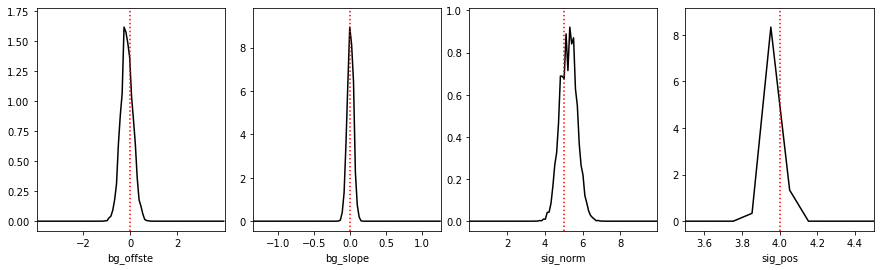

In [42]:
fig, diag = swyft.plot_1d(samples_MN, [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, contours = False)
#fig.get_axes()[0].set_xlim([8, 12])
#fig.get_axes()[1].set_xlim([-4.5, -3.5])
#fig.get_axes()[2].set_xlim([2., 8])
fig.get_axes()[3].set_xlim([3.5, 4.5])

## SWYFT

### Zoom in

In [45]:
sim = swyft.Simulator(model, ['bg_offset', 'bg_slope', 'sig_norm', 'sig_pos'], dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [46]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 4
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 4)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [53]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [[0], [1], [2], [3]])
task.run(rounds = 2, N = 10000, train_args = dict(batch_size = 128, max_epochs = 100), head = swyft.DefaultHead)
#task.run(rounds = 1, N = 1000, train_args = dict(batch_size = 128, max_epochs = 30), head = Head)

Creating new store.
Store: Adding 10004 new samples to simulator store.
Training: lr=0.001, Epoch=48, VL=2.071
Bounds: Truncating...
Bounds: ...done. New volue is V=0.03056
Store: Adding 9547 new samples to simulator store.
Training: lr=0.001, Epoch=32, VL=2.561
Bounds: Truncating...
Bounds: ...done. New volue is V=0.004062
CPU times: user 1min 45s, sys: 30.8 s, total: 2min 16s
Wall time: 2min 59s


In [57]:
task.run(rounds = 1, N = 10000, train_args = dict(batch_size = 128, max_epochs = 100), head = swyft.DefaultHead)

Store: Adding 8779 new samples to simulator store.
Training: lr=0.001, Epoch=31, VL=2.693
Bounds: Truncating...
Bounds: ...done. New volue is V=0.0009305


In [58]:
print([h[1].volume for h in task.history])

[0.03055528706818394, 0.004061887864599206, 0.000930453490288339]


In [59]:
post = task.history[-1][0]
samples = post.sample(100000, obs0)

(3.5, 4.5)

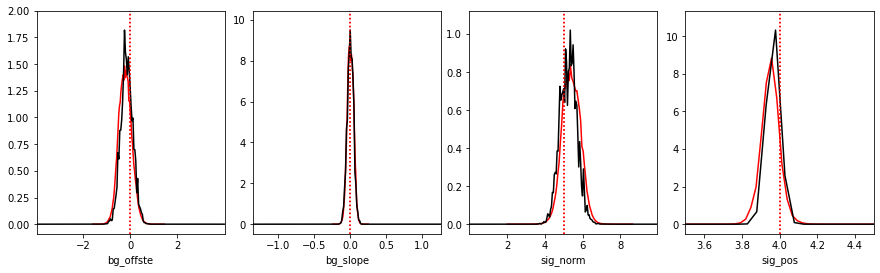

In [61]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='r', contours = False)
swyft.plot_1d(samples_MN, [0, 1, 2, 3], bins = 200, figsize=(15,4), truth = v0, fig = fig, contours = False)
fig.get_axes()[3].set_xlim([3.5, 4.5])

In [62]:
s = []
for i in [0, 1, 2]:
    post = task.history[i][0]
    samples = post.sample(100000, obs0)
    s.append(samples)

(3.5, 4.5)

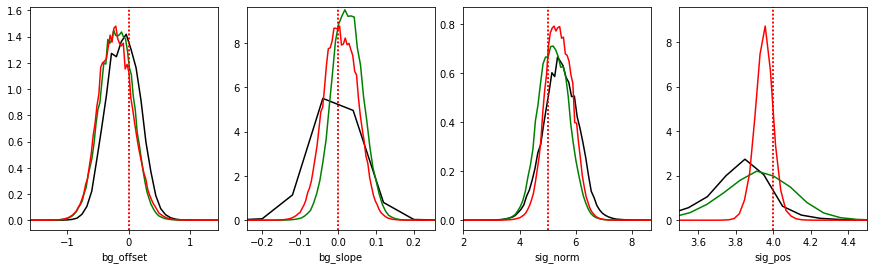

In [64]:
fig, diag = swyft.plot_1d(s[0], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='k', contours = False)
fig, diag = swyft.plot_1d(s[1], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='g', contours = False, fig = fig)
fig, diag = swyft.plot_1d(s[2], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='r', contours = False, fig = fig)
fig.get_axes()[3].set_xlim([3.5, 4.5])

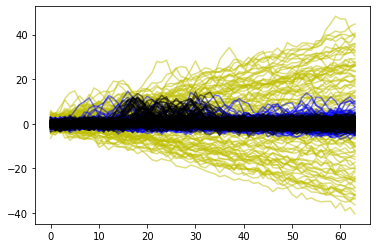

In [83]:
for i, c in zip([0, 1, 2], ['y', 'b', 'k']):
    for j in range(100):
        y = task.history[i][0].dataset[j][0]['y']
        plt.plot(y, color=c, alpha = 0.5)

### Zoom in with CNN

In [107]:
sim = swyft.Simulator(model, ['bg_offset', 'bg_slope', 'sig_norm', 'sig_pos'], dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [110]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 32
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(1, 4, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(4, 8, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(8, 16, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(16*6, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 32)
        )

    def forward(self, obs):
        x=obs['y']
        x = self.onl_f(x)
        #print(x.shape)
        x = x.unsqueeze(1)
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        x = x.reshape(-1, 16*6)
        #print(x.shape)
        x = self.mlp(x)
        #print(x.shape)
        
        f = x

        return f

In [111]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [[0], [1], [2], [3]])
task.run(rounds = 3, N = 10000, train_args = 
         dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)
#task.run(rounds = 1, N = 1000, train_args = dict(batch_size = 128, max_epochs = 30), head = Head)

Creating new store.
Store: Adding 10111 new samples to simulator store.
Training: lr=4.9e-07, Epoch=57, VL=2.123
Bounds: Truncating...
Bounds: ...done. New volue is V=0.04521
Store: Adding 9562 new samples to simulator store.
Training: lr=7.8e-06, Epoch=37, VL=2.368
Bounds: Truncating...
Bounds: ...done. New volue is V=0.00661
Store: Adding 8599 new samples to simulator store.
Training: lr=1.5e-08, Epoch=63, VL=2.454
Bounds: Truncating...
Bounds: ...done. New volue is V=0.001653
CPU times: user 3min 46s, sys: 54.9 s, total: 4min 41s
Wall time: 6min 1s


In [112]:
print([h[1].volume for h in task.history])

[0.045206180159263226, 0.006609853800316441, 0.0016528780880533226]


In [113]:
post = task.history[-1][0]
samples = post.sample(100000, obs0)

(3.5, 4.5)

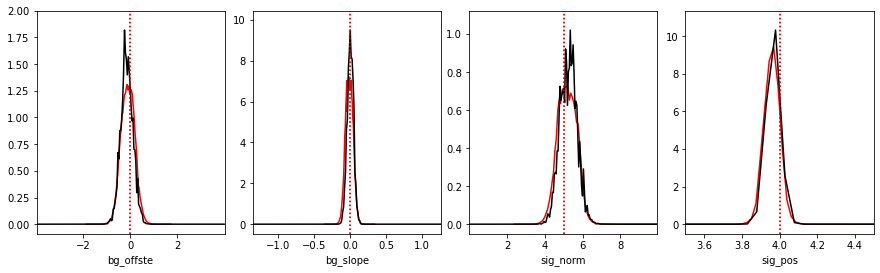

In [114]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='r', contours = False)
swyft.plot_1d(samples_MN, [0, 1, 2, 3], bins = 200, figsize=(15,4), truth = v0, fig = fig, contours = False)
fig.get_axes()[3].set_xlim([3.5, 4.5])

In [115]:
s = []
for i in [0, 1, 2]:
    post = task.history[i][0]
    samples = post.sample(100000, obs0)
    s.append(samples)

(3.5, 4.5)

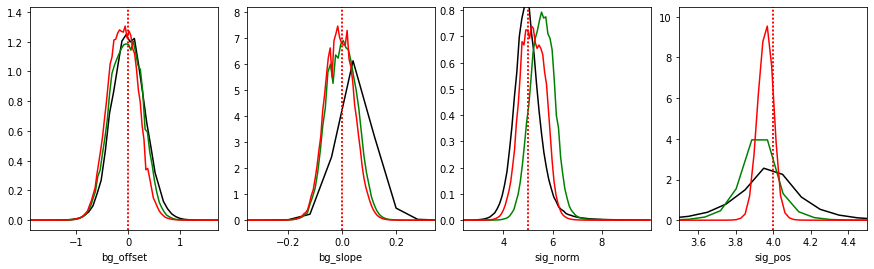

In [116]:
fig, diag = swyft.plot_1d(s[0], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='k', contours = False)
fig, diag = swyft.plot_1d(s[1], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='g', contours = False, fig = fig)
fig, diag = swyft.plot_1d(s[2], [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='r', contours = False, fig = fig)
fig.get_axes()[3].set_xlim([3.5, 4.5])

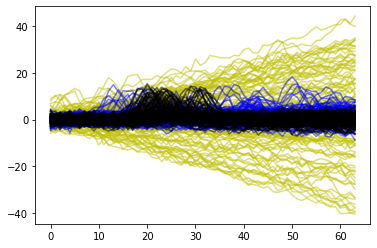

In [117]:
for i, c in zip([0, 1, 2], ['y', 'b', 'k']):
    for j in range(100):
        y = task.history[i][0].dataset[j][0]['y']
        plt.plot(y, color=c, alpha = 0.5)